In [1]:
# Import libraries
from collections import defaultdict,Counter
import importlib,math
from importlib import reload  
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as scipy
from scipy import stats
from scipy.sparse import csr_matrix
from scipy.spatial import distance
from scipy.sparse.linalg import norm
from sklearn import cluster,metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import paired_distances,cosine_similarity,cosine_distances,paired_euclidean_distances
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors.kde import KernelDensity

from sklearn.feature_selection import VarianceThreshold
pd.options.display.max_columns=201
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
import seaborn as sns



In [2]:
#Read input data
train_file='data/train.dat'
file_input=[]
with open(train_file) as read_file:
    file_input = read_file.read().splitlines()


In [3]:
# Separate terms and term frequencies in to terms,term_freq lists
docs=[]
terms=[]
term_freq=[]
all_terms=[]
for i in range(len(file_input)):
    docs.append([int(n) for n in file_input[i].split()])
    doc_term=[]
    for j in range(0,len(docs[i]),2):
        doc_term.append(docs[i][j])
        all_terms.append(docs[i][j])
        #print(i,j)
    terms.append(doc_term)
    doc_term_freq=[]
    for k in range(1,len(docs[i]),2):
        doc_term_freq.append(docs[i][k])
        #print(i,j)
    term_freq.append(doc_term_freq)
        


In [4]:
all_terms=np.unique(all_terms)
nnz=0
#Build a matrix with documents as rows, terms as columns, term frequencies as values
mat=np.zeros((len(file_input),max(all_terms)+1), dtype=float)
for i in range(len(terms)):
    mat_row=i
    for j in range(len(terms[i])):
            mat_col=terms[i][j]
            mat[mat_row][mat_col]=term_freq[i][j]
        
mat1=mat



In [5]:

#Normalize the matrix
mat2=preprocessing.normalize(mat, norm='l2', axis=1)

In [6]:
# Use SVD to reduce dimensionality
tsvd = TruncatedSVD(n_components=8,random_state=42)
mat3 = tsvd.fit(mat2).transform(mat2)


In [7]:
# Calculate cosine distances between all documents 
dist_mat=np.zeros((mat3.shape[0],mat3.shape[0]), dtype=float)
cos_dist=cosine_distances(mat3,mat3)


In [8]:

dist_mat=cos_dist.copy()
print(dist_mat.mean())
print(dist_mat.shape)




0.4913159032477317
(8580, 8580)


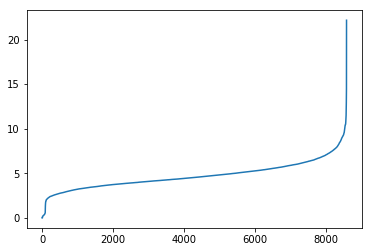

In [9]:
#
knn=dist_mat.copy()

ns = 7
nbrs = NearestNeighbors(n_neighbors=ns).fit(knn)
distances, indices = nbrs.kneighbors(knn)


distanceDec = sorted(distances[:,ns-1])



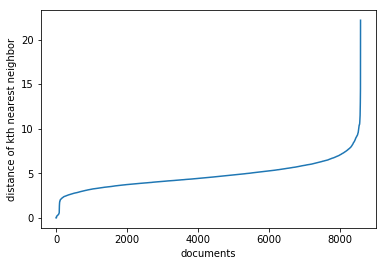

In [46]:
plt.ylabel('distance of kth nearest neighbor')
plt.xlabel('documents')
plt.plot(list(range(1,dist_mat.shape[0]+1)), distanceDec)


In [47]:
plt.savefig('kth_plot.png')

<Figure size 432x288 with 0 Axes>

In [11]:
# Find points within epsilon
def find_neighbors(dist_mat,col_num, eps, doc_num,cluster_labels):
    neighbor_loc = []
    for indx_neighbor in range(0, col_num):
        if((dist_mat[doc_num][indx_neighbor]<= eps) and (cluster_labels[indx_neighbor]<=0 )):
            neighbor_loc.append(indx_neighbor)
        
    return neighbor_loc


In [12]:
# DBSCAN algorithm
def dbscan_algo(eps,MinPts, dist_mat):
    label=0
    row_num=dist_mat.shape[0]
    col_num=dist_mat.shape[1]
    noise_pts=[]
    cluster_labels = [-2]*dist_mat.shape[0]
    border_pts = []
    core_pts = []
    num_labels=0
    # for each document, find other documents with distance < epsilon
    for index1 in range(len(cluster_labels)):
        
        if cluster_labels[index1]<0 :
            cluster_labels[index1]=-1
            doc_num=index1
    
    
            neighbors_loc = find_neighbors(dist_mat,col_num,eps,doc_num,cluster_labels)
            num_of_neighbors=len(neighbors_loc)
            # If the points within epsilon > MinPts, then it is a core point
            # Create a new cluster label, assign this label to all the unvisited and noise points
            if num_of_neighbors>MinPts and cluster_labels[doc_num]<0:
                label=label+1
                #print(label,num_of_neighbors)
    
                core_pts.append(doc_num)
                for indx_neighbor in range(len(neighbors_loc)):
                        label_index=neighbors_loc[indx_neighbor]
                        cluster_labels[label_index]=int(label)
            else:
                # If the points within epsilon<=MinPts, assign them as noise point
                noise_pts.append(doc_num)
        else:
            num_labels=num_labels+1
                    
    # Check if the noise points are border points
    # If not, they will remain as noise points
    for index1 in range(len(noise_pts)):
        
        if cluster_labels[index1]==-1 :
            doc_num=index1
        noise_core_dist=[]
        noise_label=-1
        noise_dist=0
        for j in range(len(core_pts)):
            if dist_mat[noise_pts[index1]][core_pts[j]]>noise_dist:
                cluster_labels[noise_pts[index1]]=cluster_labels[core_pts[j]]
    print('eps = ',eps, '    MinPts = ',MinPts)
    #print('   Noise Points = ',len(noise_pts))
    print('Lables_count : ', Counter(cluster_labels))
    
    return cluster_labels      

In [38]:
eps=0.22


# Calculate Silhouette score
sil_score_list=[]
min_pts=[]
for MinPts in range(3, 22,2):
        min_pts.append(MinPts)
        cluster_labels = dbscan_algo(eps,MinPts,dist_mat)
        sil_score=metrics.silhouette_score(dist_mat, cluster_labels)
        sil_score_list.append(sil_score)
        print("Silhouette_Score = ", sil_score,' \n')




eps =  0.22     MinPts =  3
Lables_count :  Counter({4: 1502, 2: 1127, 7: 966, 6: 879, 1: 864, 8: 659, 9: 395, 3: 332, 14: 326, 10: 276, 12: 186, 5: 176, 11: 174, 16: 141, 22: 101, 13: 93, 15: 78, 20: 62, 17: 60, 18: 58, 25: 38, 29: 20, 21: 19, 23: 18, 19: 13, 24: 5, 26: 5, 28: 4, 27: 3})
Silhouette_Score =  0.05629483294338555  

eps =  0.22     MinPts =  5
Lables_count :  Counter({4: 1502, 2: 1127, 7: 966, 6: 879, 1: 864, 8: 659, 9: 395, 3: 332, 14: 326, 10: 276, 12: 186, 5: 176, 11: 174, 16: 141, 22: 101, 13: 93, 15: 78, 20: 62, 17: 60, 18: 58, 24: 38, 26: 22, 21: 19, 23: 18, 25: 15, 19: 13})
Silhouette_Score =  0.06452246805886433  

eps =  0.22     MinPts =  7
Lables_count :  Counter({4: 1502, 2: 1127, 7: 966, 6: 879, 1: 864, 8: 659, 9: 395, 3: 332, 14: 326, 10: 276, 12: 186, 5: 176, 11: 174, 16: 141, 22: 101, 13: 93, 15: 78, 20: 62, 17: 60, 18: 58, 24: 38, 25: 37, 21: 19, 23: 18, 19: 13})
Silhouette_Score =  0.06804929724256108  

eps =  0.22     MinPts =  9
Lables_count :  Count

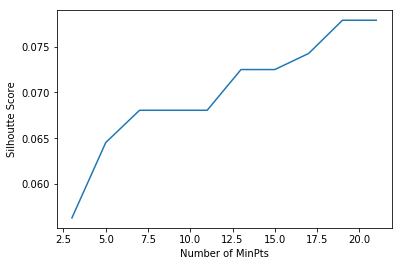

<Figure size 432x288 with 0 Axes>

In [48]:

plt.xlabel('Number of MinPts')
plt.ylabel('Silhoutte Score')
plt.plot(min_pts, sil_score_list)


plt.show()

plt.savefig('Silhouette_score_plot.png')

In [43]:
eps=0.22
MinPts=21
cluster_labels = dbscan_algo(eps,MinPts,dist_mat)


eps =  0.22     MinPts =  21
Lables_count :  Counter({4: 1502, 2: 1127, 7: 966, 6: 879, 1: 864, 8: 659, 9: 395, 3: 332, 14: 326, 10: 276, 12: 186, 5: 176, 11: 174, 16: 141, 21: 101, 22: 96, 13: 93, 15: 78, 19: 62, 17: 60, 18: 58, 20: 29})


In [41]:
np.savetxt('pr3_final_5.dat', cluster_labels, delimiter=" ", fmt="%s")